In [33]:
%run './model/corpus.py'

import networkx as nx
import numpy as np
import polars as pl

import itertools

import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from torch_geometric.utils.convert import to_networkx, from_networkx

import sklearn

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 9)})


In [2]:
corpus = Corpus("Organizations")

c = corpus
df_full = c.citation_df
G_citation_full = c.citation_graph


            Graph: DiGraph with 34154 nodes and 386394 edges
            Df: (34164, 13)
        


In [3]:
n = 1000

most_cited_nodes = list(dict(sorted(nx.in_degree_centrality(G_citation_full).items(), key=lambda x: x[1], reverse=True)).keys())[:n]

G_citation = nx.DiGraph(nx.subgraph(G_citation_full, most_cited_nodes))
G_citation.remove_nodes_from(list(nx.isolates(G_citation)))
df = df_full.filter(pl.col('Doi').is_in(list(G_citation.nodes)))

dois, texts = df.select([pl.col('Doi'), pl.col('Text')])
dois, texts = dois.to_list(), texts.to_list()

In [4]:
doi_pairs = list(itertools.product(dois, dois))
n_pairs = len(doi_pairs)

In [5]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Node2Vec

In [6]:
pyg_citation = from_networkx(G_citation)

In [7]:
print('Self loops:\t', pyg_citation.has_self_loops())
print('Isolates:\t', pyg_citation.has_isolated_nodes())
print('Directed:\t', pyg_citation.is_directed())
print('Undirected:\t', pyg_citation.is_undirected())
# print('Num Classes:\t', pyg_citation.num_classes)
print('Num Edges:\t', pyg_citation.num_edges)
print('Num Nodes:\t', pyg_citation.num_nodes)
print('Node Features:\t', pyg_citation.num_node_features)
print('Edge Features:\t', pyg_citation.num_edge_features)

Self loops:	 False
Isolates:	 False
Directed:	 True
Undirected:	 False
Num Edges:	 9755
Num Nodes:	 995
Node Features:	 0
Edge Features:	 0


In [8]:
pyg_citation

Data(edge_index=[2, 9755], num_nodes=995)

In [9]:
train_size = 0.70

nodes = pyg_citation.edge_index.numpy()
nodes = np.unique(list(nodes[0]) + list(nodes[1]))

train_set, test_val_set = sklearn.model_selection.train_test_split(nodes, train_size=train_size, random_state=1)
test_set, val_set = sklearn.model_selection.train_test_split(test_val_set, train_size=0.5, random_state=1)

print(f'Train: {len(train_set)}, Test: {len(test_set)}, Validation: {len(val_set)}')
assert(len(train_set) + len(test_set) + len(val_set) == len(nodes))

Train: 696, Test: 149, Validation: 150


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# build test train val masks
train_mask = torch.zeros(len(nodes), dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes), dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes), dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

pyg_citation.train_mask = train_mask
pyg_citation.test_mask = test_mask
pyg_citation.val_mask = val_mask

print("after\t\t",pyg_citation)


train mask 	 tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1])
test mask  	 tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
val mask   	 tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])
after		 Data(edge_index=[2, 9755], num_nodes=995, train_mask=[995], test_mask=[995], val_mask=[995])


In [11]:
embedding_dim = 128
walk_length = 20
context_size = 10
walks_per_node = 10

epochs = 10

node_model = Node2Vec(
    pyg_citation.edge_index,
    embedding_dim=embedding_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True
).to(device)

loader = node_model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(node_model.parameters()), lr=0.01)

for epoch in range(epochs):

    node_model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node_model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss = total_loss / len(loader)

    # node_model.eval()
    # z = node_model()
    # acc = node_model.test(z[pyg_citation.train_mask], pyg_citation.y[pyg_citation.train_mask],
    #                  z[pyg_citation.test_mask], pyg_citation.y[pyg_citation.test_mask],
    #                  max_iter=10)
    
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

node_model = node_model()
node_embeddings = dict(zip(
    G_citation.nodes(),
    node_model.detach().cpu().numpy(),
))

Epoch: 00, Loss: 6.6938
Epoch: 01, Loss: 5.7873
Epoch: 02, Loss: 5.1914
Epoch: 03, Loss: 4.7359
Epoch: 04, Loss: 4.3482
Epoch: 05, Loss: 3.9566
Epoch: 06, Loss: 3.6230
Epoch: 07, Loss: 3.3171
Epoch: 08, Loss: 3.0414
Epoch: 09, Loss: 2.7780


In [12]:
node_similarity = {}
for i, (doi1, doi2) in enumerate(doi_pairs):
    if doi1 != doi2:
        node_similarity[(doi1, doi2)] = cosine_similarity(node_embeddings[doi1], node_embeddings[doi2])
        print(f'\r{i} / {n_pairs}', flush=True, end='')

990023 / 990025

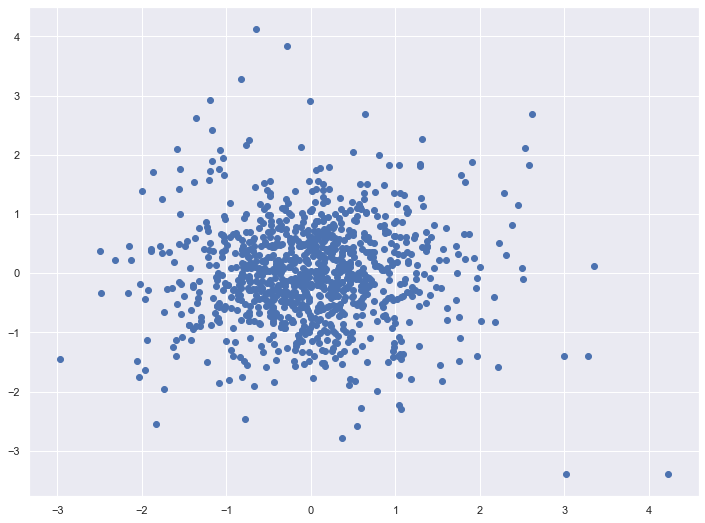

In [34]:
pca = PCA(n_components=2)
points = pca.fit_transform(list(node_embeddings.values()))

plt.plot(points[:,0], points[:,1], 'o')
plt.show()


# Doc2Vec

In [13]:
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [14]:
filtered_texts = []
for text in texts:
    tags = nltk.pos_tag(texts[0].split(' '))
    filtered_tags = list(filter(lambda x: x[1] != 'NNP', tags))
    text = list(map(lambda x: x[0], filtered_tags))
    filtered_texts.append(text)

In [15]:
documents = [TaggedDocument(text, [doi]) for doi, text in zip(dois, filtered_texts)]

doc_model = Doc2Vec(documents, vector_size=128, window=10, min_count=1, workers=4, epochs=10)

doc_embeddings = dict(zip(dois, doc_model.dv.vectors))

In [16]:
doc_similarity = {}
for (u, v) in doi_pairs:
    doc_similarity[(u, v)] = doc_model.dv.n_similarity([u], [v])

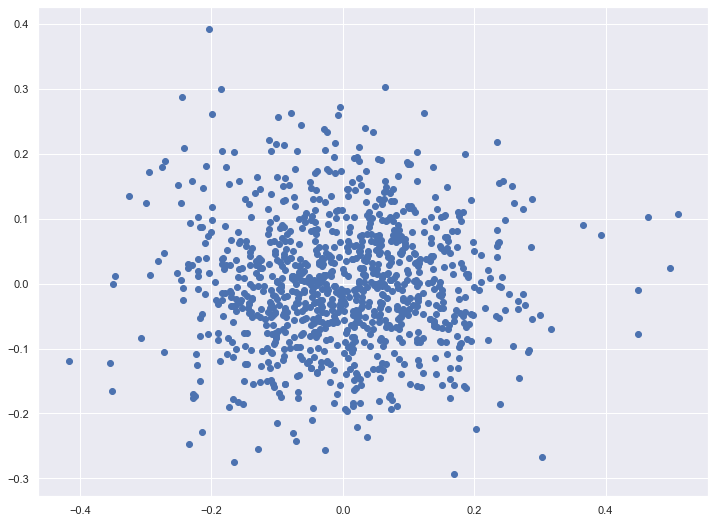

In [35]:
pca = PCA(n_components=2)
points = pca.fit_transform(list(doc_embeddings.values()))

plt.plot(points[:,0], points[:,1], 'o')
plt.show()

# Node / Doc Correlations

In [17]:
node_sim_src, node_sim_dst = zip(*node_similarity.keys())
node_sim = node_similarity.values()

df_node_sim = pl.DataFrame([
    pl.Series('DoiSrc', node_sim_src, pl.Utf8),
    pl.Series('DoiDst', node_sim_dst, pl.Utf8),
    pl.Series('NodeSimilarity', node_sim, pl.Float32),
])

doc_sim_src, doc_sim_dst = zip(*doc_similarity.keys())
doc_sim = doc_similarity.values()

df_doc_sim = pl.DataFrame([
    pl.Series('DoiSrc', doc_sim_src, pl.Utf8),
    pl.Series('DoiDst', doc_sim_dst, pl.Utf8),
    pl.Series('DocSimilarity', doc_sim, pl.Float32),
])

df_corr = df_node_sim.join(df_doc_sim, on=['DoiSrc', 'DoiDst'], how='inner')
df_corr.head(5)

DoiSrc,DoiDst,NodeSimilarity,DocSimilarity
str,str,f32,f32
"""10.1086/517897...","""10.2307/256876...",0.127382,0.989172
"""10.1086/517897...","""10.1086/227352...",0.081357,0.987412
"""10.1086/517897...","""10.1287/orsc.1...",0.043373,0.988418
"""10.1086/517897...","""10.5465/AMR.20...",-0.051609,0.986735
"""10.1086/517897...","""10.2307/258140...",-0.018036,0.983635


In [18]:
# df_corr.select(pl.col('NodeSimilarity').corr(pl.col('DocSimilarity')))
df_corr.select(pl.spearman_rank_corr('NodeSimilarity', 'DocSimilarity').alias('sp_rank_corr'))

sp_rank_corr
f64
-0.000346


In [19]:
mean_doc_vec = doc_model.dv.get_mean_vector(dois)
mean_node_vec = np.mean(node_model.detach().cpu().numpy(), axis=0)

In [20]:
len(mean_doc_vec), len(mean_node_vec)

(128, 128)